In [18]:
# Imports

import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [19]:
tuesday = pd.read_csv('C:/Users/AntonioPayá/Universidad de Oviedo/Sergio Arroni del Riego - TFG/Datasets/CIC-IDS-2017/MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')

In [20]:
# Remove Infinites
tuesday = tuesday.replace([np.inf, -np.inf], np.nan)
# Clear NaN values
tuesday = tuesday.dropna()
# Convert the ' Label',column to a scalar
tuesday[' Label'] = tuesday[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [21]:
# Split dataset into features and labels
X = tuesday.iloc[:, :-1].values
y = tuesday.iloc[:, -1].values

In [22]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
def create_batch(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return batch_x

In [24]:
normal_data = x_train[y_train == 0]
attacks_data = x_train[y_train == 1]

In [25]:
FUNCTIONAL_FEATURES = [
 ' min_seg_size_forward',' Bwd Header Length',' Destination Port'
 'Init_Win_bytes_forward',' Init_Win_bytes_backward',' Bwd Packets/s'
 'Total Length of Fwd Packets',' Subflow Fwd Bytes',' Max Packet Length'
 'Bwd Packet Length Max',' Avg Bwd Segment Size',' Bwd Packet Length Mean'
 ' Fwd Packet Length Max',' Average Packet Size',' Packet Length Std'
 ' Packet Length Mean',' Bwd Packet Length Std',' Bwd Packet Length Min'
 ' Fwd Packet Length Std',' Fwd Packet Length Min',' Min Packet Length'
 ' Fwd Packet Length Mean',' Avg Fwd Segment Size',' act_data_pkt_fwd'
 ' Total Fwd Packets','Subflow Fwd Packets',' Total Backward Packets']
print(len(FUNCTIONAL_FEATURES))
FUNCTIONAL_FEATURES_IDEXES = [tuesday.columns.get_loc(c) for c in tuesday.columns if c not in FUNCTIONAL_FEATURES]
print(FUNCTIONAL_FEATURES_IDEXES, len(FUNCTIONAL_FEATURES_IDEXES))
NON_FUNCTIONAL_FEATURES_IDEXES = [tuesday.columns.get_loc(c) for c in tuesday.columns if c in FUNCTIONAL_FEATURES][:-1]
print(NON_FUNCTIONAL_FEATURES_IDEXES, len(NON_FUNCTIONAL_FEATURES_IDEXES))
print(len(tuesday.columns))

19
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78] 68
[3, 7, 13, 35, 52, 53, 54, 62, 63, 67] 10
79


In [26]:
BATCH_SIZE = 400 # Batch size
MAX_EPOCH = 50 # How many generator iterations to train for

G_INPUT = len(NON_FUNCTIONAL_FEATURES_IDEXES) # Dimension of the input to the generator
D_INPUT = len(FUNCTIONAL_FEATURES_IDEXES) + len(NON_FUNCTIONAL_FEATURES_IDEXES) # Dimension of the input to the discriminator

G_OUTPUT_DIM = len(NON_FUNCTIONAL_FEATURES_IDEXES) # Dimension of the output from the generator
D_OUTPUT_DIM = 1 # Dimension of the output from the discriminator
print(G_INPUT, D_INPUT, G_OUTPUT_DIM, D_OUTPUT_DIM)

CLAMP = 0.01
CRITIC_ITERS = 5

10 78 10 1


In [27]:
class Generator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim //2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim // 2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,output_dim),
        )
    def forward(self, noise_dim, raw_attack, nonfunctional_features_index):
        batch_size = len(raw_attack)
        noise = Variable(th.Tensor(np.random.uniform(0,1,(batch_size, noise_dim))))
        generator_out = self.layer(noise)
        # Keep the functional features
        adversarial_attack = raw_attack.detach().clone()
        for i in range(batch_size):
            adversarial_attack[i][nonfunctional_features_index] = generator_out[i]
        return adversarial_attack

class Discriminator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Discriminator, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim * 2, input_dim *2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2 , input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,input_dim//2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim//2,output_dim),
        )

    def forward(self,x):
        return self.layer(x)

In [28]:
generator = Generator(G_INPUT,G_OUTPUT_DIM)
discriminator = Discriminator(D_INPUT,D_OUTPUT_DIM)

optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.0001)

In [29]:
from sklearn.ensemble import RandomForestClassifier
ids_model = RandomForestClassifier()
ids_model.fit(x_train, y_train)

RandomForestClassifier()

In [30]:
def train_generator(generator, discriminator, optimizer_G, noise_dim, attack_traffic):
    for p in discriminator.parameters():  
        p.requires_grad = False
    optimizer_G.zero_grad()
     # GAN-G Generate Adversarial Attack
    adversarial_attack = generator(noise_dim, attack_traffic, NON_FUNCTIONAL_FEATURES_IDEXES)
    # GAN-D predict, GAN-G update parameter
    D_pred = discriminator(adversarial_attack)
    g_loss = -th.mean(D_pred)
    g_loss.backward()
    optimizer_G.step()
    return g_loss

In [31]:
def train_discriminator(discriminator, ids_model, generator, critic_iters, clamp, optimizer_D, normal_b, noise_dim, attack_traffic):
    run_d_loss = 0
    cnt = 0
    for p in discriminator.parameters(): 
        p.requires_grad = True
    for c in range(critic_iters):
        optimizer_D.zero_grad()
        for p in discriminator.parameters():
            p.data.clamp_(-clamp, clamp)
        # GAN-G Generate Adversarial Attack
        adversarial_attack = generator(noise_dim, attack_traffic, NON_FUNCTIONAL_FEATURES_IDEXES)
        ids_input = th.cat((adversarial_attack,normal_b))
        l = list(range(len(ids_input)))
        np.random.shuffle(l)
        ids_input = ids_input[l]
        # IDS predict
        ids_pred = ids_model.predict(ids_input.detach().numpy())
        pred_attack = ids_input[ids_pred == 1]
        pred_normal = ids_input[ids_pred == 0]
        if len(pred_attack) == 0:
            cnt += 1
            break
        # Make GAN-D input
        D_noraml = discriminator(Variable(th.Tensor(pred_normal)))
        D_attack= discriminator(Variable(th.Tensor(pred_attack)))
        # Loss and Update Parameter
        loss_normal = th.mean(D_noraml)
        loss_attack = th.mean(D_attack)
        d_loss = loss_attack - loss_normal
        d_loss.backward()
        optimizer_D.step()
        run_d_loss += d_loss.item()
    return run_d_loss, cnt


In [32]:
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    # Make data to feed IDS contain: Attack & Normal
    o_ids_input = th.cat((raw_attack, normal))
    a_ids_input = th.cat((adversarial_attack,normal))
    # Shuffle Input
    l = list(range(len(a_ids_input)))
    np.random.shuffle(l)
    o_ids_input = o_ids_input[l]
    a_ids_input = a_ids_input[l]
    # IDS Predict Label
    o_pred_label = th.Tensor(ids_model.predict(o_ids_input))
    a_pred_label = th.Tensor(ids_model.predict(a_ids_input))
    # True Label
    ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    return origin_dr, adversarial_dr

IDSGAN start training
----------------------------------------------------------------------------------------------------
Epoch: 0, G_loss: -222942953.3154, D_loss: -439248044.0604, Origin DR: 1.0000, Adversarial DR: 0.9937


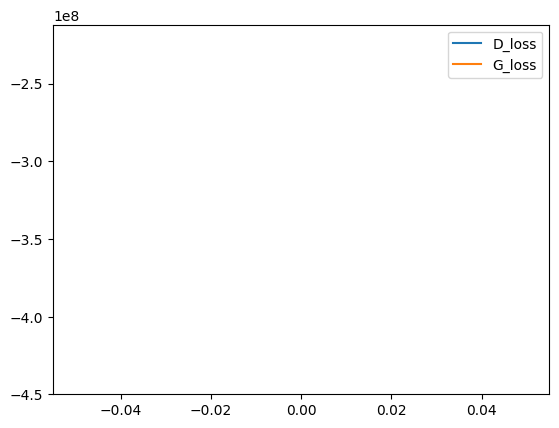

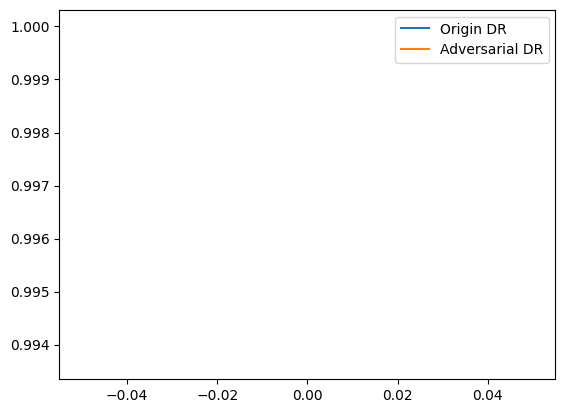

Epoch: 1, G_loss: -224505545.0000, D_loss: -439180761.1000, Origin DR: 1.0000, Adversarial DR: 0.9893


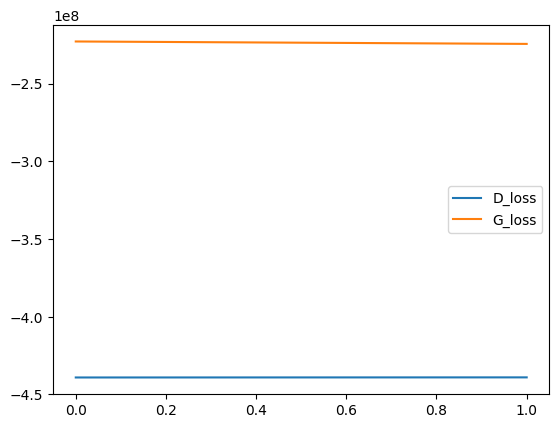

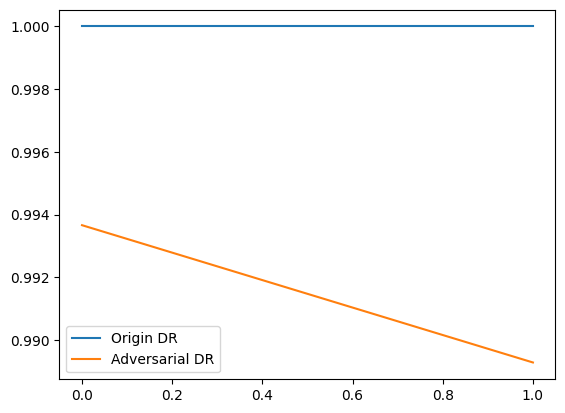

Epoch: 2, G_loss: -224553897.6250, D_loss: -437588235.0188, Origin DR: 1.0000, Adversarial DR: 0.9876


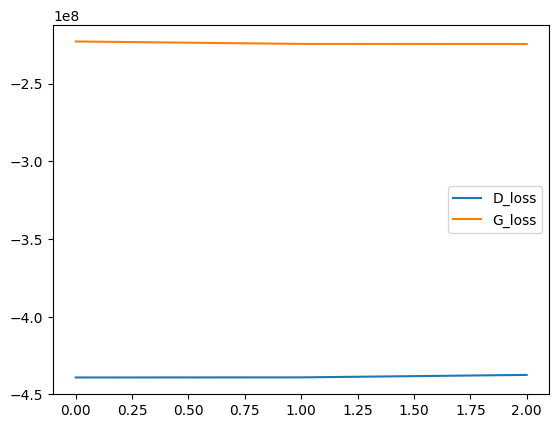

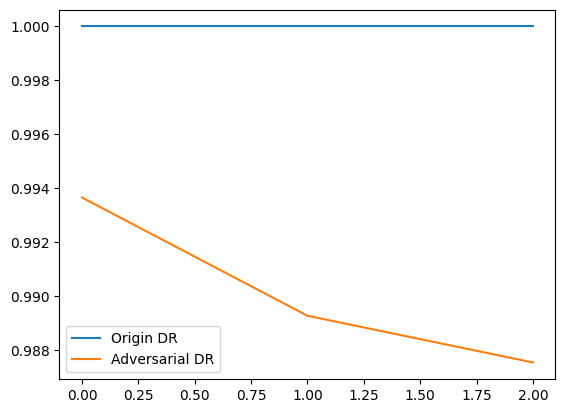

Epoch: 3, G_loss: -224395937.5625, D_loss: -403789036.7563, Origin DR: 1.0000, Adversarial DR: 0.9469


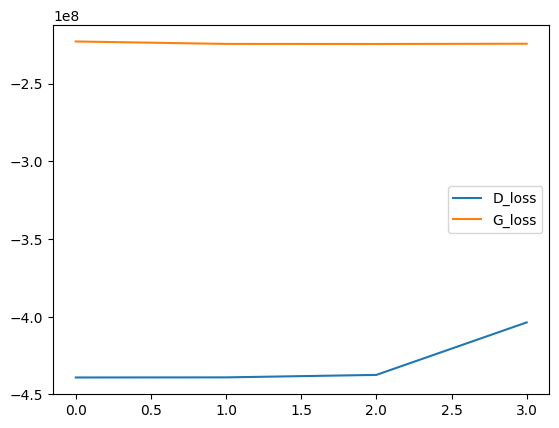

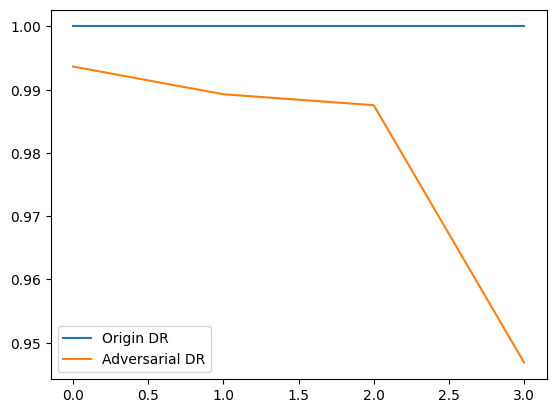

Epoch: 4, G_loss: -218869764.3125, D_loss: -279725080.6812, Origin DR: 1.0000, Adversarial DR: 0.7938


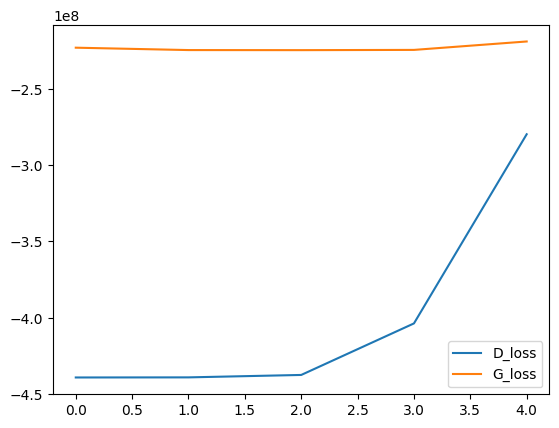

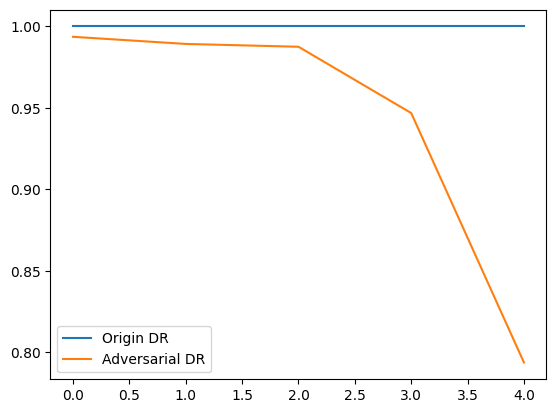

Epoch: 5, G_loss: -214823727.6562, D_loss: -278620251.7437, Origin DR: 1.0000, Adversarial DR: 0.7919


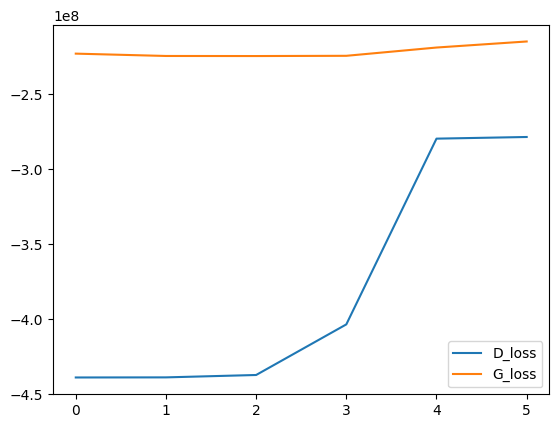

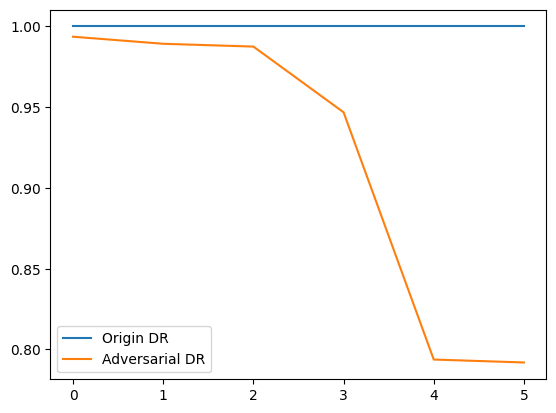

Epoch: 6, G_loss: -214778737.8125, D_loss: -281633939.1375, Origin DR: 1.0000, Adversarial DR: 0.7960


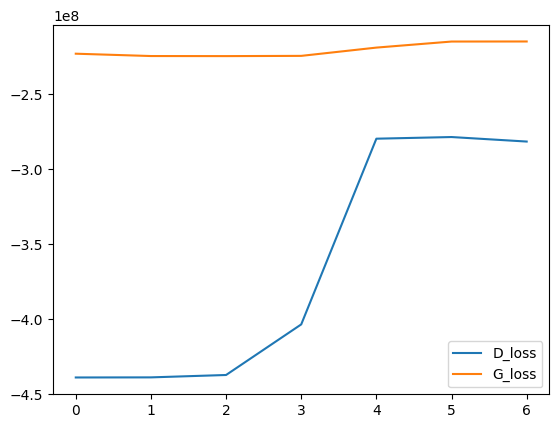

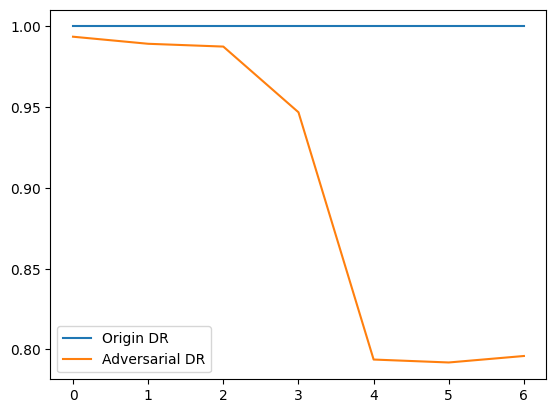

Epoch: 7, G_loss: -220635687.1250, D_loss: -284916467.9187, Origin DR: 1.0000, Adversarial DR: 0.8002


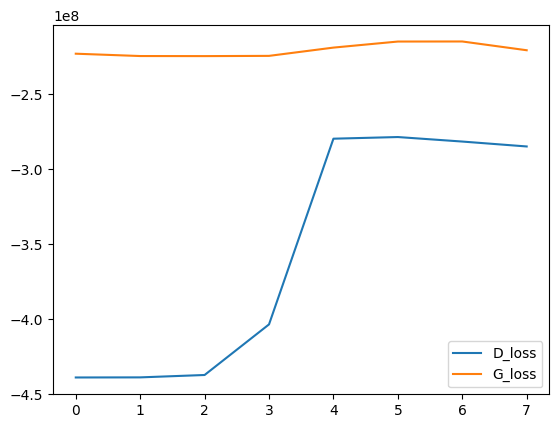

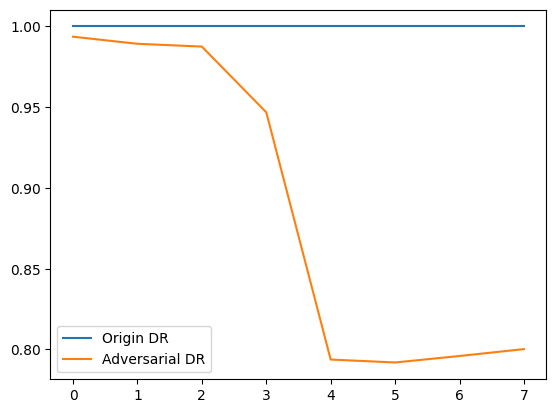

Epoch: 8, G_loss: -216807705.8438, D_loss: -277434755.3875, Origin DR: 1.0000, Adversarial DR: 0.7910


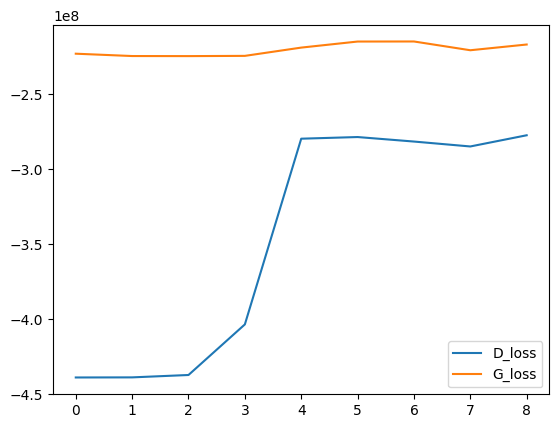

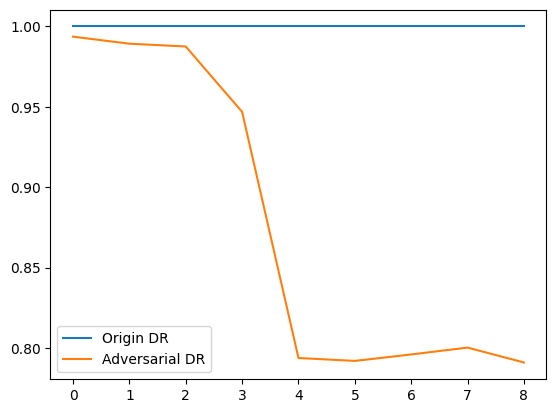

Epoch: 9, G_loss: -215014583.7500, D_loss: -277292419.4187, Origin DR: 1.0000, Adversarial DR: 0.7902


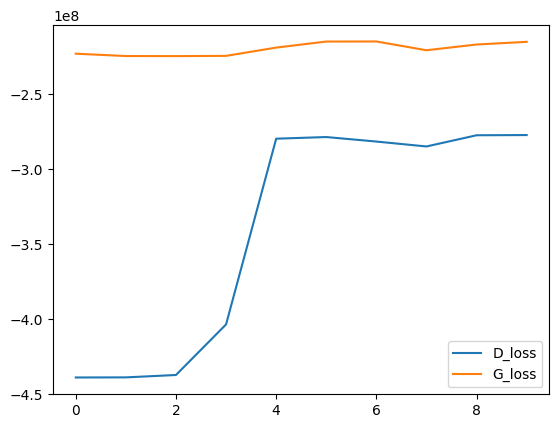

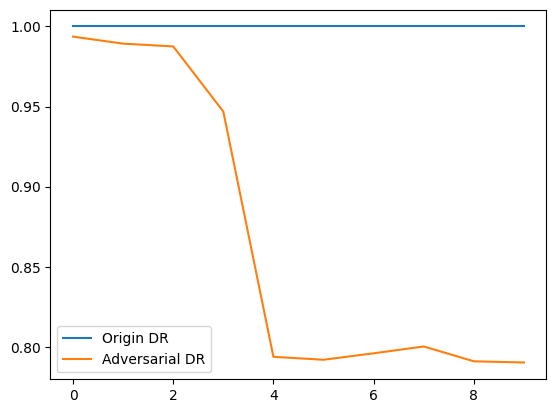

Epoch: 10, G_loss: -214233885.6875, D_loss: -276959150.2250, Origin DR: 1.0000, Adversarial DR: 0.7902


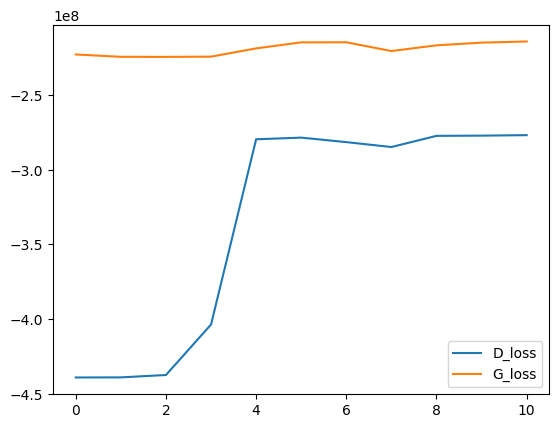

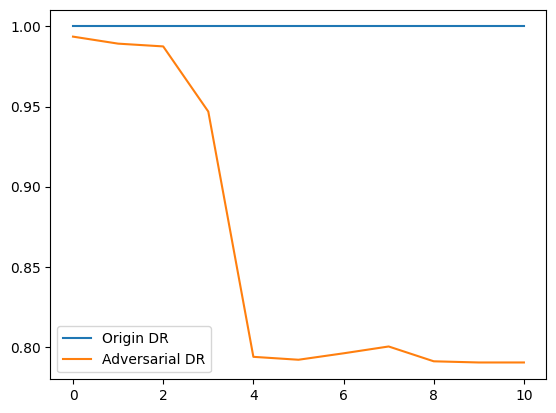

Epoch: 11, G_loss: -215716907.8750, D_loss: -277111118.4000, Origin DR: 1.0000, Adversarial DR: 0.7902


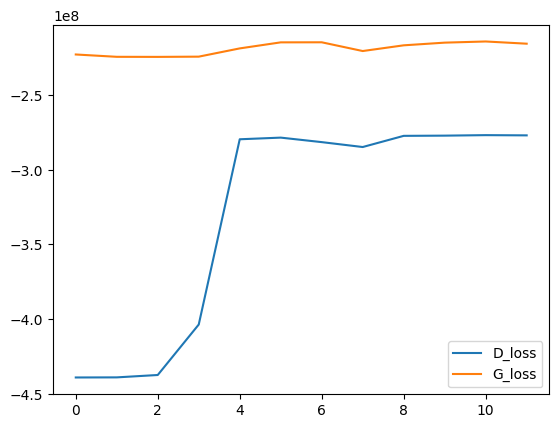

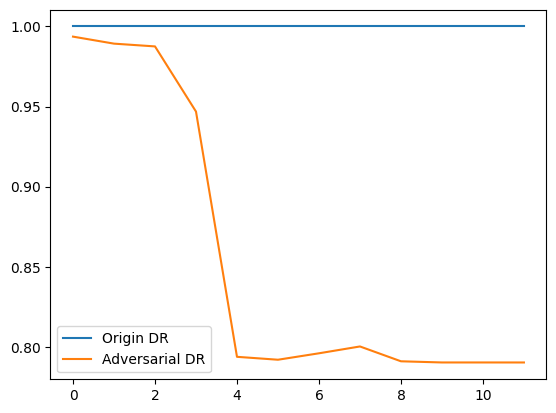

KeyboardInterrupt: 

In [33]:
d_losses,g_losses = [],[]
o_dr, a_dr = [],[]
generator.train()
discriminator.train()
batch_attack = create_batch(attacks_data, BATCH_SIZE)
cnt = -5
print("IDSGAN start training")
print("-"*100)

for epoch in range(15):
    batch_normal = create_batch(normal_data, BATCH_SIZE)
    cnt = 0
    run_g_loss = 0.
    run_d_loss = 0.
    epoch_o_drs, epoch_a_drs = [], []

    for i, bn in enumerate(batch_normal):
        normal_b = th.Tensor(bn.astype("float64"))
        attack_traffic  = Variable(th.Tensor(batch_attack[i % len(batch_attack)]))
        # Train Generator
        g_loss = train_generator(generator, discriminator, optimizer_G, G_INPUT, attack_traffic)
        run_g_loss += g_loss.item()

        # Train Discriminator
        d_loss, current_cnt = train_discriminator(discriminator, ids_model, generator, CRITIC_ITERS, CLAMP, optimizer_D, normal_b, G_INPUT, attack_traffic)
        run_d_loss += d_loss
        cnt += current_cnt

        # CALC Epoch DR
        adversarial_attack = generator(G_INPUT, attack_traffic, NON_FUNCTIONAL_FEATURES_IDEXES).detach()
        origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_traffic, adversarial_attack)
        epoch_o_drs.append(origin_dr)
        epoch_a_drs.append(adversarial_dr)

    if cnt >= (len(normal_data)/BATCH_SIZE):
        print("Not exist predicted attack traffic")
        break
    d_losses.append(run_d_loss/CRITIC_ITERS)
    g_losses.append(run_g_loss)
    epoch_o_dr = np.mean(epoch_o_drs)
    epoch_a_dr = np.mean(epoch_a_drs)
    o_dr.append(epoch_o_dr)
    a_dr.append(epoch_a_dr)

    print("Epoch: %d, G_loss: %.4f, D_loss: %.4f, Origin DR: %.4f, Adversarial DR: %.4f" % (epoch, run_g_loss, run_d_loss/CRITIC_ITERS, epoch_o_dr, epoch_a_dr))

    # Show Graph
    # Loss-Graph
    plt.plot(d_losses,label = "D_loss")
    plt.plot(g_losses, label = "G_loss")
    plt.legend()
    plt.title("Loss-Graph Random Forest classifier")
    plt.show()
    # DR-Graph
    plt.plot(o_dr,label = "Origin DR")
    plt.plot(a_dr, label = "Adversarial DR")
    plt.title("DR-Graph Random Forest classifier")
    plt.legend()
    plt.show()
    

In [ ]:
# Generate Adversarial samples and save to file
attack_traffic = Variable(th.Tensor(batch_attack[0]))
adversarial_attack = generator(G_INPUT, attack_traffic, NON_FUNCTIONAL_FEATURES_IDEXES).detach()
adversarial_attack = adversarial_attack.numpy()
adversarial_attack = pd.DataFrame(adversarial_attack, columns=tuesday.columns[:-1])
adversarial_attack.to_csv("adversarial_attack.csv", index=False)

attack_traffic_np = attack_traffic.numpy()
attack_traffic_np = pd.DataFrame(attack_traffic_np, columns=tuesday.columns[:-1])
attack_traffic_np.to_csv("attack_traffic.csv", index=False)

IndexError: index 78 is out of bounds for dimension 0 with size 78